In [1]:
%matplotlib inline

import glob
import math
import os.path
import pickle

import matplotlib.pyplot as plt
import pandas
from matplotlib import cm
from matplotlib.colors import Normalize
from pandas import DataFrame as df
import numpy as np


In [2]:
def load_data(data_file="./sample_data/sample_data.csv"):
    # load data in csv file into DataFrame
    df = pandas.read_csv(data_file)
    print(f"Data loaded: {df.shape}")
    return df

data = load_data()


Data loaded: (18, 32772)


In [3]:
def parse_data(df_table: df):
    # parse data in DataFrame into numpy.ndarray
    assert (df_table is not None)

    tissue_class_column_np = [1 if x else 0 for x in df_table.loc[:, "tissue_classification"]]

    pixel_starting = 4
    pixel_ending = len(df_table.columns)
    pixel_columns_np = df_table.iloc[:, pixel_starting:pixel_ending].values
    intensity_data = pixel_columns_np[:, 0:128 * 128]
    lifetime_data = pixel_columns_np[:, 128 * 128:pixel_columns_np.shape[1]]

    return np.asarray(intensity_data), np.asarray(lifetime_data), np.asarray(tissue_class_column_np)

intensity, lifetime, classes = parse_data(data)
print("# Frames: ", intensity.shape[0])

# Frames:  18


In [4]:
def post_processing(intensity: np.ndarray, lifetime: np.ndarray):
    intensity[np.isnan(intensity)] = 0.0
    lifetime[np.isnan(lifetime)] = 0.0

    mask = (intensity > 0)
    threshold = np.ma.array(intensity, mask=mask).mean()
    intensity[intensity < threshold] = 0
    for i in range(intensity.shape[0]):
        if intensity[i] < threshold:
            intensity[i] = 0
            lifetime[i] = 0

    lifetime[lifetime > 5] = 0

    intensity = np.resize(intensity, (128, 128))
    lifetime = np.resize(lifetime, (128, 128))

    ## lifetime: grey to rgb
    mask = np.resize(mask.astype(int), (128, 128))
    norm = Normalize(vmin=0.0, vmax=255.0)
    lifetime_color = cm.jet(norm(lifetime))
    lifetime_color_rgb = lifetime_color[:, :, 0:3]
    lifetime_color_rgb[:, :, 0] *= mask
    lifetime_color_rgb[:, :, 1] *= mask
    lifetime_color_rgb[:, :, 2] *= mask

    ## weighting
    bgcolor = 0
    intensity_alpha_mask = intensity/intensity.max()
    intensity_alpha_mask[intensity_alpha_mask < 0.05] = 0
    lifetime_alpha_rgb = np.zeros(intensity_alpha_mask.shape + (3,))
    lifetime_alpha_rgb[:, :, 0] = ((1 - lifetime_color[:, :, 3]) * bgcolor) + intensity_alpha_mask * lifetime_color[:, :, 0]
    lifetime_alpha_rgb[:, :, 0] *= mask
    lifetime_alpha_rgb[:, :, 1] = ((1 - lifetime_color[:, :, 3]) * bgcolor) + intensity_alpha_mask * lifetime_color[:, :, 1]
    lifetime_alpha_rgb[:, :, 1] *= mask
    lifetime_alpha_rgb[:, :, 2] = ((1 - lifetime_color[:, :, 3]) * bgcolor) + intensity_alpha_mask * lifetime_color[:, :, 2]
    lifetime_alpha_rgb[:, :, 2] *= mask

    return intensity, lifetime, lifetime_alpha_rgb
    
index = 7
temp_it, temp_lt, temp_lt_alpha = post_processing(intensity[index], lifetime[index])
temp_lt_alpha.shape

(128, 128, 3)

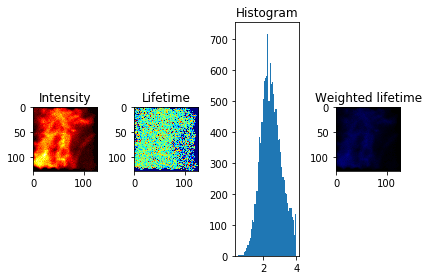

In [5]:


plt.subplot(141)
plt.imshow(temp_it, cmap="hot")
plt.title("Intensity")

plt.subplot(142)
plt.imshow(temp_lt, cmap="jet", vmin=0.5)
plt.title("Lifetime")

plt.subplot(143)
plt.hist(temp_lt.ravel(), 50, range=[0.5, 4])
plt.title("Histogram")

plt.subplot(144)
plt.imshow(temp_lt_alpha, cmap="jet", vmin=0.5)
plt.title("Weighted lifetime")

plt.tight_layout()
plt.show()